In [1]:
from random import sample
import statistics 
import json

import pandas as pd

In [2]:
f = open('./wrond_id_BERT_squad2.0_wa.txt','rt')
wrong_bert_wa = f.readlines()
f.close()

f = open('./wrond_id_BERT_squad2.0_fp.txt','rt')
wrong_bert_fp = f.readlines()
f.close()

f = open('./wrond_id_BERT_squad2.0_fn.txt','rt')
wrong_bert_fn = f.readlines()
f.close()

In [3]:
def removen(file):
    return [line.rstrip('\n') for line in file]

wrong_bert_wa = removen(wrong_bert_wa)
wrong_bert_fp = removen(wrong_bert_fp)
wrong_bert_fn = removen(wrong_bert_fn)

In [4]:
f = open('./squad/dev-v2.0.json','rb')
data = json.load(f)

data = data['data']

all_qid = []

for document in data:
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            all_qid.append(qas['id'])

len(all_qid)

right_qid = set(all_qid)-set(wrong_bert_wa)-set(wrong_bert_fp)-set(wrong_bert_fn)

In [5]:
from nltk import tokenize
from tqdm import tqdm_notebook
import re

In [6]:
f = open('./squad/dev-v2.0_predictions.json', 'rb')
prediction = json.load(f)

In [43]:
prediction

{'56ddde6b9a695914005b9628': 'France',
 '56ddde6b9a695914005b9629': '10th and 11th centuries',
 '56ddde6b9a695914005b962a': 'Denmark, Iceland and Norway',
 '56ddde6b9a695914005b962b': 'Rollo',
 '56ddde6b9a695914005b962c': '10th',
 '5ad39d53604f3c001a3fe8d1': '',
 '5ad39d53604f3c001a3fe8d2': '',
 '5ad39d53604f3c001a3fe8d3': '',
 '5ad39d53604f3c001a3fe8d4': '',
 '56dddf4066d3e219004dad5f': 'William the Conqueror',
 '56dddf4066d3e219004dad60': 'Richard I of Normandy',
 '56dddf4066d3e219004dad61': 'The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy',
 '5ad3a266604f3c001a3fea27': '',
 '5ad3a266604f3c001a3fea28': '',
 '5ad3a266604f3c001a3fea29': '',
 '5ad3a266604f3c001a3fea2a': 'Richard I of Normandy',
 '5ad3a266604f3c001a3fea2b': '',
 '56dde0379a695914005b9636': 'Northman',
 '56dde0379a695914005b9637': '9th century',
 '5ad3ab70604f3c001a3feb89': '',
 '5ad3ab70604f3c001a3feb8a': '',
 '56dde0ba66d3e219004dad75

In [7]:
def cnt_overlap(question, sentence):
    question = re.sub(r'[^A-Za-z0-9 ]+', '', question)
    sentence = re.sub(r'[^A-Za-z0-9 ]+', '', sentence)
    qwords = question.split()
    
    indexes = []
    for qword in qwords:
        wins = sentence.split()
        if qword in wins:
            indexes.append(wins.index(qword))
    
    return indexes

In [52]:
def overlap_checking_(question, pred_or_answer, sentences, doclen):

    if question == 'What was the population of the Dutch Republic before this emigration?':
        sentences.append('This was a huge influx as the entire population of the Dutch Republic amounted to ca. 2 million at that time.')
    
    if question == 'Who was one prominent Huguenot-descended arms manufacturer?':
        sentences.append('For example, E.I. du Pont, a former student of Lavoisier, established the Eleutherian gunpowder mills.')
    
    if question == 'What is included with each packet label':
        sentences.append('Each packet is labeled with a destination address, source address, and port numbers. It may also be labeled with the sequence number of the packet.')
    
    if question == 'Who allegedly coined the name Black Death?':
        sentences.append('Gasquet (1908) claimed that the Latin name atra mors (Black Death) for the 14th-century epidemic first appeared in modern times in 1631 in a book on Danish history by J.I. Pontanus')
        
    if question == 'Why would one plead guilty to a crime involving civil disobedience?':
        sentences.append('"Yes, I committed the act of which you accuse me. I don\'t deny it')
        
    if question == 'What famous civil rights leader called Harvard home?':
        sentences.append('Civil rights leader W. E. B. Du Bois')
    
    if question == 'When less workers are required, what happens to the job market?':
        sentences.append('Over the long-term, this trend increases the organic composition of capital, meaning that less workers are required in proportion to capital inputs, increasing unemployment (the \"reserve army of labour\"). This process exerts a downward pressure on wages.')
        
    if question == 'Who calculated the speed of light?':
        sentences.append('Notable faculty in physics have included the speed of light calculator A. A. Michelson')
        
    if question == 'Who had Kublai wanted to succeed him?':
        sentences.append('This emerged as early as the end of Kublai\'s reign. Kublai originally named his eldest son, Zhenjin, as the Crown Prince, but he died before Kublai in 1285. Thus, Zhenjin\'s third son, with the support of his mother Kökejin and the minister Bayan, succeeded the throne and ruled as Temür Khan, or Emperor Chengzong, from 1294 to 1307.')

    if pred_or_answer == '':
        pred_or_answer = '!@#$'
        
    maxi = -1
    ch = 0
    for sentence in sentences:
        indexes = cnt_overlap(question, sentence)
        
        #print(len(indexes)/len(sentence.split()))
        if maxi < len(indexes)/len(sentence.split()):
            maxi = len(indexes)/len(sentence.split())
            maxi_index = indexes
            max_sentence = sentence
        
        if pred_or_answer in sentence:
            return (len(indexes), (len(indexes)/doclen), (len(indexes)/len(sentence.split())), indexes, sentence)

    indexes = maxi_index
    sentence = max_sentence
    return (len(indexes), (len(indexes)/doclen), (len(indexes)/len(sentence.split())), indexes, sentence)

In [53]:
id_list = []
wtype_list = []

overlap_cnt_a_list = []
overlap_ratio_from_context_a_list = []
overlap_ratio_from_sentence_a_list = []
overlap_distribution_a_list = []
std_a_list = []

overlap_cnt_p_list = []
overlap_ratio_from_context_p_list = []
overlap_ratio_from_sentence_p_list = []
overlap_distribution_p_list = []
std_p_list = []
is_same_sentence_list = []

best_overlap_sentence_list = []

noncnt = 0
    
for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        
        document = paragraph['context']
        doclen = len(document.split())
        sentences = tokenize.sent_tokenize(document)
        
        bo
            
            overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p \
            = None, None, None, None
            
            overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a \
            = None, None, None, None
            
            asent = None
            bsent = None
            is_same_sentence = None
            
            if qas['id'] in wrong_bert_wa: 
                wtype = 'wa'
                
                tmp = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)
                if not tmp:
                    noncnt += 1
                    continue
                
                overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, asent \
                = tmp
                
                std_p = statistics.stdev(overlap_distribution_p) if len(overlap_distribution_p) > 1 else -1
                
                mini = float('inf')
                short_answer = qas['answers'][0]['text'] if len(qas['answers']) > 0 else ""
                for answer in qas['answers']:
                    if mini > len(tokenize.sent_tokenize(answer['text'])):
                        mini = len(tokenize.sent_tokenize(answer['text']))
                        short_answer = answer['text']
                
                overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, bsent \
                = overlap_checking_(qas['question'], short_answer, sentences, doclen)
                
                std_a = statistics.stdev(overlap_distribution_a) if len(overlap_distribution_a) > 1 else -1
                
                is_same_sentence = (asent == bsent)
                
            elif qas['id'] in wrong_bert_fp:
                wtype = 'fp'
                
                tmp = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)
                if not tmp:
                    noncnt += 1
                    continue
                    
                overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, _ \
                = tmp
                
                std_p = statistics.stdev(overlap_distribution_p) if len(overlap_distribution_p) > 1 else -1
                
                mini = float('inf')
                short_answer = qas['answers'][0]['text'] if len(qas['answers']) > 0 else ""
                for answer in qas['answers']:
                    if mini > len(tokenize.sent_tokenize(answer['text'])):
                        mini = len(tokenize.sent_tokenize(answer['text']))
                        short_answer = answer['text']
                
                overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, bsent \
                = overlap_checking_(qas['question'], short_answer, sentences, doclen)
                
                std_a = statistics.stdev(overlap_distribution_a) if len(overlap_distribution_a) > 1 else -1
                
                
            elif qas['id'] in wrong_bert_fn:
                wtype = 'fn'
                
                tmp = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)
                if not tmp:
                    noncnt += 1
                    continue
                    
                overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, _ \
                = tmp
                
                std_p = statistics.stdev(overlap_distribution_p) if len(overlap_distribution_p) > 1 else -1
                
                mini = float('inf')
                short_answer = qas['answers'][0]['text'] if len(qas['answers']) > 0 else ""
                for answer in qas['answers']:
                    if mini > len(tokenize.sent_tokenize(answer['text'])):
                        mini = len(tokenize.sent_tokenize(answer['text']))
                        short_answer = answer['text']
                
                overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, _ \
                = overlap_checking_(qas['question'], short_answer, sentences, doclen)
                
                std_a = statistics.stdev(overlap_distribution_a) if len(overlap_distribution_a) > 1 else -1
                
            else:
                
                wtype = 'right'
                
                if prediction[qas['id']] == "":
                    wtype = 'no_answer_right'
                
                
                check = 0
                tmp = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)

                if not tmp:
                    check = 1
                    noncnt += 1
                    continue

                overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, _ \
                = tmp

                std_p = statistics.stdev(overlap_distribution_p) if len(overlap_distribution_p) > 1 else -1

                mini = float('inf')
                short_answer = qas['answers'][0]['text'] if len(qas['answers']) > 0 else ""
                for answer in qas['answers']:
                    if mini > len(tokenize.sent_tokenize(answer['text'])):
                        mini = len(tokenize.sent_tokenize(answer['text']))
                        short_answer = answer['text']


                overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, _ \
                = overlap_checking_(qas['question'], short_answer, sentences, doclen)

                std_a = statistics.stdev(overlap_distribution_a) if len(overlap_distribution_a) > 1 else -1

            
            id_list.append(qas['id'])
            wtype_list.append(wtype)

            overlap_cnt_a_list.append(overlap_cnt_a)
            overlap_ratio_from_context_a_list.append(overlap_ratio_from_context_a)
            overlap_ratio_from_sentence_a_list.append(overlap_ratio_from_sentence_a)
            overlap_distribution_a_list.append(overlap_distribution_a)
            std_a_list.append(std_a)

            overlap_cnt_p_list.append(overlap_cnt_p)
            overlap_ratio_from_context_p_list.append(overlap_ratio_from_context_p)
            overlap_ratio_from_sentence_p_list.append(overlap_ratio_from_sentence_p)
            overlap_distribution_p_list.append(overlap_distribution_p)
            std_p_list.append(std_p)
            
            is_same_sentence_list.append(is_same_sentence)

d = {'id': id_list, 'wrong_type': wtype_list, 
     'overlap_cnt_a': overlap_cnt_a_list, 'overlap_ratio_from_context_a': overlap_ratio_from_context_a_list,
     'overlap_ratio_from_sentence_a': overlap_ratio_from_sentence_a_list, 'overlap_distribution_a': overlap_distribution_a_list,
     'std_a': std_a_list,
     'overlap_cnt_p': overlap_cnt_p_list, 'overlap_ratio_from_context_p': overlap_ratio_from_context_p_list,
     'overlap_ratio_from_sentence_p': overlap_ratio_from_sentence_p_list, 'overlap_distribution_p': overlap_distribution_p_list,
     'std_p': std_p_list,
     'is_same_sentence': is_same_sentence_list}
                    
df = pd.DataFrame(data=d)

In [37]:
id_list = []
wtype_list = []

overlap_cnt_a_list = []
overlap_ratio_from_context_a_list = []
overlap_ratio_from_sentence_a_list = []
overlap_distribution_a_list = []
std_a_list = []

overlap_cnt_p_list = []
overlap_ratio_from_context_p_list = []
overlap_ratio_from_sentence_p_list = []
overlap_distribution_p_list = []
std_p_list = []
is_same_sentence_list = []


noncnt = 0
    
for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        
        document = paragraph['context']        
        doclen = len(document.split())
        sentences = tokenize.sent_tokenize(document)
        
        for qas in paragraph['qas']:
            
            overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p \
            = None, None, None, None
            
            overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a \
            = None, None, None, None
            
            asent = None
            bsent = None
            is_same_sentence = None
            
            if qas['id'] in wrong_bert_wa: 
                wtype = 'wa'
                
                tmp = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)
                if not tmp:
                    noncnt += 1
                    continue
                
                overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, asent \
                = tmp
                
                std_p = statistics.stdev(overlap_distribution_p) if len(overlap_distribution_p) > 1 else -1
                
                mini = float('inf')
                short_answer = qas['answers'][0]['text']
                for answer in qas['answers']:
                    if mini > len(tokenize.sent_tokenize(answer['text'])):
                        mini = len(tokenize.sent_tokenize(answer['text']))
                        short_answer = answer['text']
                
                overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, bsent \
                = overlap_checking_(qas['question'], short_answer, sentences, doclen)
                
                std_a = statistics.stdev(overlap_distribution_a) if len(overlap_distribution_a) > 1 else -1
                
                is_same_sentence = (asent == bsent)
                
            elif qas['id'] in wrong_bert_fp:
                wtype = 'fp'
                
                tmp = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)
                if not tmp:
                    noncnt += 1
                    continue
                    
                overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, _ \
                = tmp
                
                std_p = statistics.stdev(overlap_distribution_p) if len(overlap_distribution_p) > 1 else -1
                
                #print(tmp)
                #print(overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a)
                #print("\n")
                
                #break
                
                
            elif qas['id'] in wrong_bert_fn:
                wtype = 'fn'
                
                mini = float('inf')
                short_answer = qas['answers'][0]['text']
                for answer in qas['answers']:
                    if mini > len(tokenize.sent_tokenize(answer['text'])):
                        mini = len(tokenize.sent_tokenize(answer['text']))
                        short_answer = answer['text']
                
                overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, _ \
                = overlap_checking_(qas['question'], short_answer, sentences, doclen)
                
                std_a = statistics.stdev(overlap_distribution_a) if len(overlap_distribution_a) > 1 else -1
                
            else:
                
                wtype = 'right'
                
                if prediction[qas['id']] == "":
                    wtype = 'no_answer_right'
                
                else:
                    check = 0
                    tmp = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)
                    
                    if not tmp:
                        check = 1
                        noncnt += 1
                        break
                    
                    overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, _ \
                    = tmp
                    
                    std_p = statistics.stdev(overlap_distribution_p) if len(overlap_distribution_p) > 1 else -1
                    
                    mini = float('inf')
                    short_answer = qas['answers'][0]['text']
                    for answer in qas['answers']:
                        if mini > len(tokenize.sent_tokenize(answer['text'])):
                            mini = len(tokenize.sent_tokenize(answer['text']))
                            short_answer = answer['text']
                    

                    overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, _ \
                    = overlap_checking_(qas['question'], short_answer, sentences, doclen)

                    std_a = statistics.stdev(overlap_distribution_a) if len(overlap_distribution_a) > 1 else -1
                
                if check:
                    continue
            
            id_list.append(qas['id'])
            wtype_list.append(wtype)

            overlap_cnt_a_list.append(overlap_cnt_a)
            overlap_ratio_from_context_a_list.append(overlap_ratio_from_context_a)
            overlap_ratio_from_sentence_a_list.append(overlap_ratio_from_sentence_a)
            overlap_distribution_a_list.append(overlap_distribution_a)
            std_a_list.append(std_a)

            overlap_cnt_p_list.append(overlap_cnt_p)
            overlap_ratio_from_context_p_list.append(overlap_ratio_from_context_p)
            overlap_ratio_from_sentence_p_list.append(overlap_ratio_from_sentence_p)
            overlap_distribution_p_list.append(overlap_distribution_p)
            std_p_list.append(std_p)
            
            is_same_sentence_list.append(is_same_sentence)

d = {'id': id_list, 'wrong_type': wtype_list, 
     'overlap_cnt_a': overlap_cnt_a_list, 'overlap_ratio_from_context_a': overlap_ratio_from_context_a_list,
     'overlap_ratio_from_sentence_a': overlap_ratio_from_sentence_a_list, 'overlap_distribution_a': overlap_distribution_a_list,
     'std_a': std_a_list,
     'overlap_cnt_p': overlap_cnt_p_list, 'overlap_ratio_from_context_p': overlap_ratio_from_context_p_list,
     'overlap_ratio_from_sentence_p': overlap_ratio_from_sentence_p_list, 'overlap_distribution_p': overlap_distribution_p_list,
     'std_p': std_p_list,
     'is_same_sentence': is_same_sentence_list}
                    
df = pd.DataFrame(data=d)

In [39]:
df.loc[df['wrong_type'] == 'fn']

,id,wrong_type,overlap_cnt_a,overlap_ratio_from_context_a,overlap_ratio_from_sentence_a,overlap_distribution_a,std_a,overlap_cnt_p,overlap_ratio_from_context_p,overlap_ratio_from_sentence_p,overlap_distribution_p,std_p,is_same_sentence
28,56dde1d966d3e219004dad8d,fn,1.0,0.009901,0.058824,[11],-1.000000,NaN,NaN,NaN,None,1.870829,None
78,56de1563cffd8e1900b4b5c4,fn,0.0,0.000000,0.000000,[],-1.000000,NaN,NaN,NaN,None,-1.000000,None
83,56de15dbcffd8e1900b4b5c9,fn,0.0,0.000000,0.000000,[],-1.000000,NaN,NaN,NaN,None,-1.000000,None
98,56de16ca4396321400ee25c8,fn,6.0,0.062500,0.400000,"[7, 11, 12, 13, 7, 2]",4.131182,NaN,NaN,NaN,None,5.315073,None
113,56de17f9cffd8e1900b4b5e0,fn,0.0,0.000000,0.000000,[],-1.000000,NaN,NaN,NaN,None,8.020806,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11856,5737a9afc3c5551400e51f62,fn,1.0,0.014706,0.055556,[3],-1.000000,NaN,NaN,NaN,None,3.847077,None
11857,5737a9afc3c5551400e51f63,fn,2.0,0.029412,0.111111,"[10, 15]",3.535534,NaN,NaN,NaN,None,3.847077,None
11858,5737a9afc3c5551400e51f64,fn,5.0,0.073529,0.192308,"[2, 4, 5, 6, 15]",5.029911,NaN,NaN,NaN,None,3.847077,None
11867,5737aafd1c456719005744fe,fn,7.0,0.055556,0.304348,"[3, 3, 4, 11, 12, 3, 4]",3.988077,NaN,NaN,NaN,None,7.289915,None


In [11]:
only_TF = [x for x in is_same_sentence_list if x != None]

In [12]:
df.loc[df['is_same_sentence']]

ValueError: cannot index with vector containing NA / NaN values

## wrong answer analysis

In [54]:
#same sentence ratio
print('same sentence ratio: {:.04}'.format(only_TF.count(True)/len(only_TF)))

same sentence ratio: 0.844


In [55]:
import seaborn as sns

Text(0.5, 1.0, 'overlap for all_overlap_cnt_p')

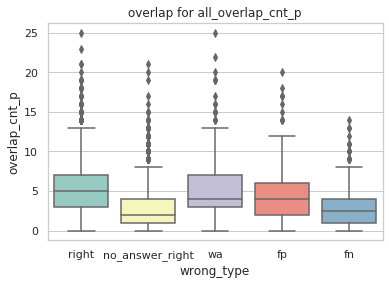

In [28]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_cnt_p",
                 data=df, palette="Set3")
ax.set_title('overlap for all_overlap_cnt_p')

Text(0.5, 1.0, 'overlap for all_overlap_ratio_from_context_p')

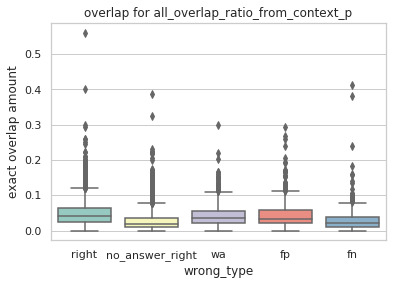

In [20]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_ratio_from_context_p",
                 data=df, palette="Set3")
ax.set_ylabel('exact overlap amount')
ax.set_title('overlap for all_overlap_ratio_from_context_p')

Text(0.5, 1.0, 'Overlap between predicted sentence and question per right & wrong type')

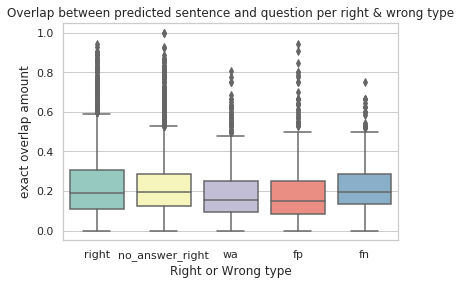

In [56]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_ratio_from_sentence_p",
                 data=df, palette="Set3")
ax.set_ylabel('exact overlap amount')
ax.set_xlabel('Right or Wrong type')
ax.set_title('Overlap between predicted sentence and question per right & wrong type')

Text(0.5, 1.0, 'overlap for all_overlap_cnt_a')

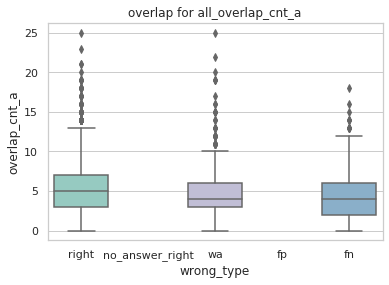

In [18]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_cnt_a",
                 data=df, palette="Set3")
ax.set_title('overlap for all_overlap_cnt_a')

Text(0.5, 1.0, 'overlap for all_overlap_ratio_from_context_a')

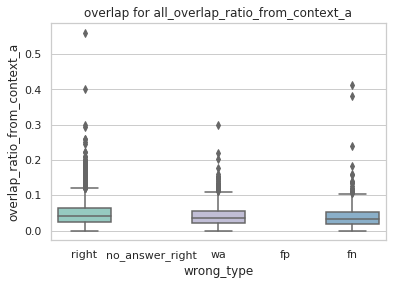

In [19]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_ratio_from_context_a",
                 data=df, palette="Set3")
ax.set_title('overlap for all_overlap_ratio_from_context_a')

Text(0.5, 1.0, 'Overlap between answer sentence and question per right & wrong type')

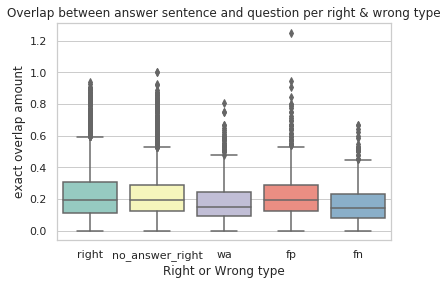

In [57]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_ratio_from_sentence_a",
                 data=df, palette="Set3")
ax.set_ylabel('exact overlap amount')
ax.set_xlabel('Right or Wrong type')
ax.set_title('Overlap between answer sentence and question per right & wrong type')

In [21]:
prediction_score = df.loc[(df['wrong_type']=='fp') | (df['wrong_type']=='right') | (df['wrong_type'] == 'wa')]

Text(0.5, 1.0, 'overlap_cnt_p')

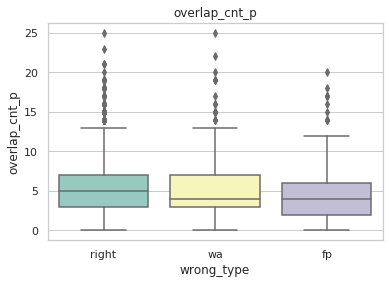

In [22]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_cnt_p",
                 data=prediction_score, palette="Set3")
ax.set_title('overlap_cnt_p')

Text(0.5, 1.0, 'overlap_ratio_from_context_p')

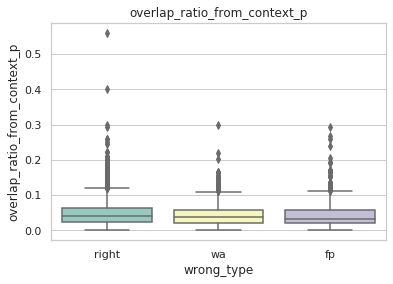

In [23]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_ratio_from_context_p",
                 data=prediction_score, palette="Set3")
ax.set_title('overlap_ratio_from_context_p')

Text(0.5, 1.0, 'overlap_ratio_from_sentence_p')

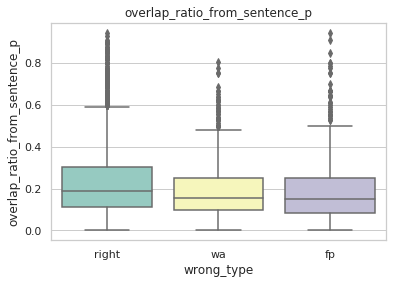

In [24]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_ratio_from_sentence_p",
                 data=prediction_score, palette="Set3")
ax.set_title('overlap_ratio_from_sentence_p')

In [25]:
answer_score = df.loc[(df['wrong_type']=='fn') | (df['wrong_type']=='right') | (df['wrong_type'] == 'wa')]

Text(0.5, 1.0, 'overlap_cnt_a')

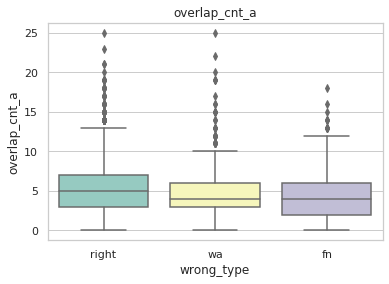

In [26]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_cnt_a",
                 data=answer_score, palette="Set3")
ax.set_title('overlap_cnt_a')

Text(0.5, 1.0, 'overlap_ratio_from_context_a')

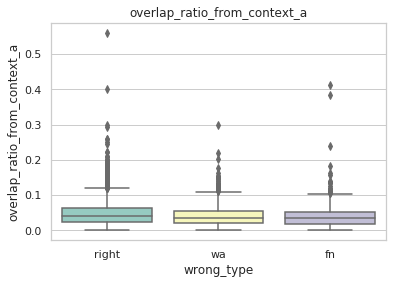

In [27]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_ratio_from_context_a",
                 data=answer_score, palette="Set3")
ax.set_title('overlap_ratio_from_context_a')

Text(0.5, 1.0, 'overlap_ratio_from_sentence_a')

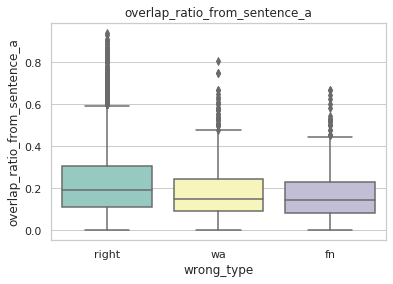

In [28]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="wrong_type", y="overlap_ratio_from_sentence_a",
                 data=answer_score, palette="Set3")
ax.set_title('overlap_ratio_from_sentence_a')

In [29]:
df

,id,wrong_type,overlap_cnt_a,overlap_ratio_from_context_a,overlap_ratio_from_sentence_a,overlap_distribution_a,std_a,overlap_cnt_p,overlap_ratio_from_context_p,overlap_ratio_from_sentence_p,overlap_distribution_p,std_p,is_same_sentence
0,56ddde6b9a695914005b9628,right,1.0,0.008850,0.037037,[22],-1.000000,1.0,0.008850,0.037037,[22],-1.000000,None
1,56ddde6b9a695914005b9629,right,5.0,0.044248,0.185185,"[8, 9, 1, 12, 22]",7.635444,5.0,0.044248,0.185185,"[8, 9, 1, 12, 22]",7.635444,None
2,56ddde6b9a695914005b962a,right,1.0,0.008850,0.030303,[4],-1.000000,1.0,0.008850,0.030303,[4],-1.000000,None
3,56ddde6b9a695914005b962b,right,2.0,0.017699,0.060606,"[4, 20]",11.313708,2.0,0.017699,0.060606,"[4, 20]",11.313708,None
4,56ddde6b9a695914005b962c,right,5.0,0.044248,0.178571,"[18, 7, 8, 13, 5]",5.263079,3.0,0.026549,0.111111,"[9, 1, 19]",9.018500,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11868,5737aafd1c456719005744ff,fn,4.0,0.031746,0.173913,"[9, 6, 4, 11]",3.109126,NaN,NaN,NaN,None,7.289915,None
11869,5ad28ad0d7d075001a4299cc,no_answer_right,NaN,NaN,NaN,None,3.109126,NaN,NaN,NaN,None,7.289915,None
11870,5ad28ad0d7d075001a4299cd,no_answer_right,NaN,NaN,NaN,None,3.109126,NaN,NaN,NaN,None,7.289915,None
11871,5ad28ad0d7d075001a4299ce,no_answer_right,NaN,NaN,NaN,None,3.109126,NaN,NaN,NaN,None,7.289915,None


In [30]:
set(df.wrong_type)

{'fn', 'fp', 'no_answer_right', 'right', 'wa'}

In [31]:
df.std_a != -1

0        False
1         True
2        False
3         True
4         True
         ...  
11868     True
11869     True
11870     True
11871     True
11872     True
Name: std_a, Length: 11873, dtype: bool

In [32]:
df.loc[(df.wrong_type == 'right') & (df.std_a != -1)]

,id,wrong_type,overlap_cnt_a,overlap_ratio_from_context_a,overlap_ratio_from_sentence_a,overlap_distribution_a,std_a,overlap_cnt_p,overlap_ratio_from_context_p,overlap_ratio_from_sentence_p,overlap_distribution_p,std_p,is_same_sentence
1,56ddde6b9a695914005b9629,right,5.0,0.044248,0.185185,"[8, 9, 1, 12, 22]",7.635444,5.0,0.044248,0.185185,"[8, 9, 1, 12, 22]",7.635444,None
3,56ddde6b9a695914005b962b,right,2.0,0.017699,0.060606,"[4, 20]",11.313708,2.0,0.017699,0.060606,"[4, 20]",11.313708,None
4,56ddde6b9a695914005b962c,right,5.0,0.044248,0.178571,"[18, 7, 8, 13, 5]",5.263079,3.0,0.026549,0.111111,"[9, 1, 19]",9.018500,None
9,56dddf4066d3e219004dad5f,right,6.0,0.026549,0.136364,"[3, 26, 42, 3, 5, 41]",18.782971,6.0,0.026549,0.136364,"[3, 26, 42, 3, 5, 41]",18.782971,None
18,56dde0379a695914005b9637,right,5.0,0.102041,0.102041,"[6, 42, 11, 6, 39]",18.130085,5.0,0.102041,0.102041,"[6, 42, 11, 6, 39]",18.130085,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11850,5737a84dc3c5551400e51f5c,right,4.0,0.036697,0.307692,"[10, 11, 12, 1]",5.066228,4.0,0.036697,0.307692,"[10, 11, 12, 1]",5.066228,None
11855,5737a9afc3c5551400e51f61,right,6.0,0.088235,0.333333,"[14, 4, 6, 8, 5, 11]",3.847077,6.0,0.088235,0.333333,"[14, 4, 6, 8, 5, 11]",3.847077,None
11864,5737aafd1c456719005744fb,right,7.0,0.055556,0.241379,"[17, 10, 4, 6, 8, 9, 10]",4.099942,7.0,0.055556,0.241379,"[17, 10, 4, 6, 8, 9, 10]",4.099942,None
11865,5737aafd1c456719005744fc,right,4.0,0.031746,0.137931,"[17, 10, 13, 15]",2.986079,4.0,0.031746,0.137931,"[17, 10, 13, 15]",2.986079,None


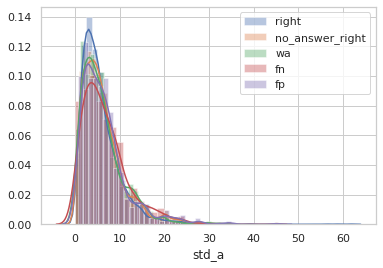

In [33]:
# Import library and dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# Method 1: on the same Axis
sns.distplot( df.loc[(df.wrong_type == 'right') & (df.std_a != -1)]["std_a"] , label="right")
sns.distplot( df.loc[(df.wrong_type == 'no_answer_right') & (df.std_a != -1)]["std_a"] , label="no_answer_right")
sns.distplot( df.loc[(df.wrong_type == 'wa') & (df.std_a != -1)]["std_a"] , label="wa")
sns.distplot( df.loc[(df.wrong_type == 'fn') & (df.std_a != -1)]["std_a"] , label="fn")
sns.distplot( df.loc[(df.wrong_type == 'fp') & (df.std_a != -1)]["std_a"] , label="fp")
plt.legend()
 
#sns.plt.show()

## wrong_answer_analysis

In [13]:
from random import sample

In [14]:
wrong_answer_from_same_sentence_id = set(df.loc[df['is_same_sentence'] == True].id)

In [15]:
wrong_answer_from_same_sentence_id_sample = sample(wrong_answer_from_same_sentence_id, 30)

In [16]:
for document in data:
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            if qas['id'] in wrong_answer_from_same_sentence_id_sample:
                print("*context: ", paragraph['context'])
                print("*question: ", qas['question'])
                print("*answer: ", qas['answers'][0]['text'])
                print("*prediction: ", prediction[qas['id']])
                print("\n")

*context:  The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East. The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy into which they assimilated. They adopted the Gallo-Romance language of the Frankish land they settled, their dialect becoming known as Norman, Normaund or Norman French, an important literary language. The Duchy of Normandy, which they formed by treaty with the French crown, was a great fief of medieval France, and under Richard I of Normandy was forged into a cohesive and formidable principality in feudal tenure. The Normans are noted both for their culture, such as their unique Romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. Norman adventurers founded the Kingdom of Sicily under Roger II after conquering southern Italy on the Saracens and Byzantines, and an exp

In [18]:
import spacy
nlp = spacy.load('en')

In [19]:
candidate = ['when', 'how', 'where', 'which', 'what', 'who', 'how many', 'whose', 'whom', 'why']
how_words = ['many','tall','much','tall','old', 'often', 'deep', 'high', 'long', 'far', 'wide']
changelist = ['(what?)', '(what)', '(which?)', '(Which?)', '(which)', '(Which)']

In [20]:
def changepartsent(word, reword, sentence):
    '''
    Change the part of sentence from word to reword
    @param word
         	@word that targeted to change
    @param reword
         	@word in sentence is replaced to @reword
    @param sentence
         	sentence string
    @return the changed string
    '''
    
    if type(word) is list:
        for w in word:
            sentence = sentence.replace(w,reword)

    else:
        sentence = sentence.replace(word,reword)
        sentence = sentence.replace(word[0].upper()+word[1:],reword)
    
    return sentence

In [21]:
def _wh_helper(sentence):
    doc = nlp(sentence)
    
    if sentence.startswith('name'): return 'name'
    
    if 'how' in sentence.split():
        list_of_words = sentence.split()
        if list_of_words.index('how') != len(list_of_words)-1: 
            next_word = list_of_words[list_of_words.index('how') + 1]
            if next_word in how_words:
                return 'how many'
        
    
    for w in reversed(doc):
        if w.pos_ == 'NN': continue
        else:
            for can in candidate:
                if can in w.text.split():
                    return can
            break
    
    whs = []

    for idx, token in enumerate(doc):
        for can in candidate:
            if can in token.text.split():
                return can
            
    if doc[-1].lemma_ == 'be' or doc[-1].pos_ == 'ADP':
        return 'implicit_what'
    
    if 'name' in sentence.lower():
        return 'name'
    
    return 'none'

def findWHword(sentence):
    
    sentence = sentence.lower()
    osentence = sentence
    
    x = re.findall("\(wha.*?\)", sentence)

    if x != []:
        return 'cloze'
    
    if sentence.count('\"') > 0:
        sentence = changepartsent(re.findall(r'"([^"]*)"', sentence), 'QUOTES', sentence)
    if (sentence.count('\'')-sentence.count('\'s')) % 2 == 0 and sentence.count('\'')-sentence.count('\'s') > 0:
        sentence = changepartsent(re.findall(r"'(.*?)'", sentence), 'QUOTES', sentence)
        
    sentence = re.sub('\,.+?\,', '', sentence)
        
    wh = _wh_helper(sentence)
    if wh == 'none':
        wh = _wh_helper(osentence)
    
    return wh

In [22]:
def PosTagger(sentence):    
    '''
    POS Tagger
    
    @return the tuple of token and POS tag in sentence
    '''
    doc = nlp(sentence)
    poslist = []

    for token in doc:
        poslist.append((token.text, token.tag_))
    
    return poslist

def detailAnsType(question):
    '''
    Find detail answer type
    
    @return the detail answer type
    '''
    st = False
    ans = ''
    PTs = PosTagger(question)
    
    #print (PTs)
    
    for idx, w in enumerate(PTs):
        if w[0].lower() == 'what' or w[0].lower() == 'which':
            st = True
            continue
        #print(w)
        if st == True and (w[0].lower() == 'did' or w[0].lower() == 'does'): break
        if st == True and (w[1] == 'NN' or w[1] == 'NNP' or w[1] == 'NNS'):
            if 'kind' in w[0].lower() or 'name' in w[0].lower() or 'type' in w[0].lower() or (idx < len(PTs)-1 and "\'s" in PTs[idx+1][0].lower()):
                continue
                
            for j in range(idx, len(PTs)):
                if PTs[j][0][0].isupper():
                    ans = ''
                    break
                if not (PTs[j][1] == 'NN' or PTs[j][1] == 'NNP' or PTs[j][1] == 'NNS'):
                    if "\'s" in PTs[j][0].lower():
                        ans = ''
                        break
                    else: return (ans, PTs[j-1][0])
                ans += PTs[j][0]+' '
                
    
    return ("None","None")

In [23]:
num_of_question = {'when': 758, 
'how': 366, 
'where': 482, 
'which': 511, 
'what': 7430, 
'who': 1119, 
'how many': 903, 
'whose': 0, 
'whom': 0, 
'why': 194, 
'none': 97, 
'implicit_what': 2, 
'name': 11, 
'cloze': 0}

In [24]:
wrong_answer_from_same_sentence_id = set(df.loc[df['is_same_sentence'] == True].id)

wh_list = []
lat_list = []
wrong_qid_per_wh = dict()
for document in data:
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            if qas['id'] in wrong_answer_from_same_sentence_id:
                wh_word = findWHword(qas['question'])
                if 'who' in wh_word:
                    wh_word = 'who'
                wh_list.append(wh_word)
                
                wrong_qid_per_wh.setdefault(wh_word,[]).append(qas['id'])
                
                if wh_word == 'what':
                    lat_s,_ = detailAnsType(qas['question'])
                    lat_list.append(lat_s)

In [45]:
for wh in set(wh_list):
    print("{}: {:.04}% / {:.04}%".format(wh, wh_list.count(wh)/len(wh_list)*100, wh_list.count(wh)/num_of_question[wh]*100))

none: 1.693% / 12.37%
which: 5.219% / 7.241%
what: 62.91% / 6.003%
implicit_what: 0.141% / 50.0%
who: 5.219% / 3.307%
when: 2.116% / 1.979%
how many: 5.078% / 3.987%
name: 0.5642% / 36.36%
how: 7.757% / 15.03%
where: 6.206% / 9.129%
why: 3.103% / 11.34%


In [58]:
for wh in set(wh_list):
    print("{}: {}".format(wh, wh_list.count(wh)))

none: 12
which: 37
what: 446
implicit_what: 1
who: 37
when: 15
how many: 36
name: 4
how: 55
where: 44
why: 22


In [46]:
sorted_string = []
for lat in set(lat_list):
    ansstr = "{}: {:.04}%".format(lat, lat_list.count(lat)/len(lat_list)*100)
    sorted_string.append((ansstr, lat_list.count(lat)))
    
sorted_string.sort(key=lambda x:x[1], reverse = True)

prob = 0
for ss in sorted_string:
    print(ss[0])
    prob += ss[1]

None: 22.87%
example : 1.345%
body : 0.8969%
organization : 0.8969%
event : 0.8969%
impact : 0.8969%
things : 0.6726%
reason : 0.6726%
end : 0.6726%
age : 0.6726%
role : 0.6726%
examples : 0.6726%
term : 0.6726%
receptor : 0.6726%
country : 0.6726%
treaty : 0.6726%
goal : 0.4484%
sort : 0.4484%
powers : 0.4484%
period : 0.4484%
satellite : 0.4484%
source : 0.4484%
percentage : 0.4484%
delta : 0.4484%
success : 0.4484%
amount : 0.4484%
unit : 0.4484%
group : 0.4484%
river : 0.4484%
duty : 0.4484%
dynasty : 0.4484%
advantage : 0.4484%
p-1 : 0.4484%
imperialism : 0.4484%
time : 0.4484%
issue : 0.4484%
industry : 0.4484%
effect : 0.4484%
alumni : 0.4484%
conviction : 0.4484%
power : 0.2242%
learning experience : 0.2242%
referendums : 0.2242%
borough : 0.2242%
steam : 0.2242%
relationship : 0.2242%
expression : 0.2242%
office : 0.2242%
malum : 0.2242%
goods : 0.2242%
factors : 0.2242%
vote : 0.2242%
crops : 0.2242%
public : 0.2242%
capabilities aer : 0.2242%
district : 0.2242%
buildings : 0

In [28]:
wrong_answer_from_different_sentence_id = set(df.loc[df['is_same_sentence'] == False].id)

wrong_answer_from_different_sentence_id_sample = sample(wrong_answer_from_different_sentence_id, 30)

for document in data:
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            if qas['id'] in wrong_qid_per_wh['what']:
                print("*context: ", paragraph['context'])
                print("*question: ", qas['question'])
                print("*answers: ")
                for answer in qas['answers']:
                    print(answer['text'])
                print("*prediction: ", prediction[qas['id']])
                print("\n")

*context:  The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East. The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy into which they assimilated. They adopted the Gallo-Romance language of the Frankish land they settled, their dialect becoming known as Norman, Normaund or Norman French, an important literary language. The Duchy of Normandy, which they formed by treaty with the French crown, was a great fief of medieval France, and under Richard I of Normandy was forged into a cohesive and formidable principality in feudal tenure. The Normans are noted both for their culture, such as their unique Romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. Norman adventurers founded the Kingdom of Sicily under Roger II after conquering southern Italy on the Saracens and Byzantines, and an exp

*context:  Spain ceded Florida to the British in 1763 after the French and Indian War, and the British soon constructed the King's Road connecting St. Augustine to Georgia. The road crossed the St. Johns River at a narrow point, which the Seminole called Wacca Pilatka and the British called the Cow Ford or Cowford; these names ostensibly reflect the fact that cattle were brought across the river there. The British introduced the cultivation of sugar cane, indigo and fruits as well the export of lumber. As a result, the northeastern Florida area prospered economically more than it had under the Spanish. Britain ceded control of the territory back to Spain in 1783, after its defeat in the American Revolutionary War, and the settlement at the Cow Ford continued to grow. After Spain ceded the Florida Territory to the United States in 1821, American settlers on the north side of the Cow Ford decided to plan a town, laying out the streets and plats. They soon named the town Jacksonville, aft

In [56]:
len(wrong_qid_per_wh['implicit_what'])

1

In [49]:
wrong_ans_same_sentence = df.loc[df['is_same_sentence'] == True]

In [50]:
wrong_ans_same_sentence

,id,wrong_type,overlap_cnt_a,overlap_ratio_from_context_a,overlap_ratio_from_sentence_a,overlap_distribution_a,std_a,overlap_cnt_p,overlap_ratio_from_context_p,overlap_ratio_from_sentence_p,overlap_distribution_p,std_p,is_same_sentence
10,56dddf4066d3e219004dad60,wa,3.0,0.013274,0.081081,"[10, 2, 3]",4.358899,3.0,0.013274,0.081081,"[10, 2, 3]",4.358899,True
11,56dddf4066d3e219004dad61,wa,3.0,0.013274,0.125000,"[2, 17, 1]",8.962886,3.0,0.013274,0.125000,"[2, 17, 1]",8.962886,True
17,56dde0379a695914005b9636,wa,4.0,0.081633,0.081633,"[17, 6, 11, 6]",5.228129,4.0,0.081633,0.081633,"[17, 6, 11, 6]",5.228129,True
23,56dde0ba66d3e219004dad77,wa,3.0,0.019608,0.115385,"[14, 4, 18]",7.211103,3.0,0.019608,0.115385,"[14, 4, 18]",7.211103,True
72,56de15104396321400ee25b9,wa,2.0,0.016807,0.100000,"[13, 3]",7.071068,2.0,0.016807,0.100000,"[13, 3]",7.071068,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11705,573786b51c4567190057448e,wa,8.0,0.086957,0.235294,"[13, 14, 16, 21, 6, 10, 5, 12]",5.221863,8.0,0.086957,0.235294,"[13, 14, 16, 21, 6, 10, 5, 12]",5.221863,True
11730,57378b141c456719005744a0,wa,10.0,0.052356,0.400000,"[6, 4, 7, 8, 9, 10, 11, 3, 5, 14]",3.400980,10.0,0.052356,0.400000,"[6, 4, 7, 8, 9, 10, 11, 3, 5, 14]",3.400980,True
11732,57378b141c456719005744a2,wa,7.0,0.036649,0.241379,"[10, 17, 4, 5, 13, 14, 15]",5.014265,7.0,0.036649,0.241379,"[10, 17, 4, 5, 13, 14, 15]",5.014265,True
11780,57379829c3c5551400e51f3d,wa,5.0,0.043860,0.333333,"[6, 11, 12, 13, 7]",3.114482,5.0,0.043860,0.333333,"[6, 11, 12, 13, 7]",3.114482,True


In [58]:
print(sum(wrong_ans_different_sentence.overlap_ratio_from_sentence_p > wrong_ans_different_sentence.overlap_ratio_from_sentence_a)/len(wrong_ans_different_sentence))

0.6106870229007634


In [64]:
tmp = wrong_ans_different_sentence.overlap_ratio_from_sentence_p - wrong_ans_different_sentence.overlap_ratio_from_sentence_a

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5a11e7fe10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5a11e06910>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5a11e7f1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5a11e7fed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5a11eb8850>],
 'means': []}

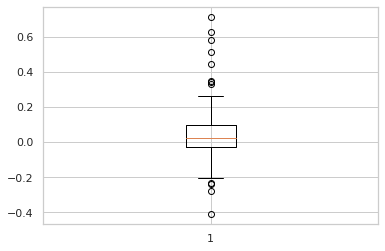

In [65]:
plt.boxplot(tmp)

In [37]:
def cnt_overlap(question, sentence):
    if question[-1] == '?': question = question[:-1]
    if not sentence[-1].isalnum(): sentence = sentence[:-1]
    qwords = question.split()
    
    print("*qwords",qwords)
    print("*sentence",sentence.split())
    
    indexes = []
    for qword in qwords:
        if qword in sentence.split():
            indexes.append(sentence.index(qword))
    
    return indexes

In [23]:
## old verison - only found on valid sentence
def overlap_checking_(question, pred_or_answer, sentences, doclen):

    for sentence in sentences:
        if pred_or_answer in sentence:
            indexes = cnt_overlap(question, sentence)

            return (len(indexes), (len(indexes)/doclen), len(indexes)/len(sentence.split()), indexes, sentence)

In [42]:
## old verison - only found on valid sentence
id_list = []
wtype_list = []

overlap_cnt_a_list = []
overlap_ratio_from_context_a_list = []
overlap_ratio_from_sentence_a_list = []
overlap_distribution_a_list = []
std_a_list = []

overlap_cnt_p_list = []
overlap_ratio_from_context_p_list = []
overlap_ratio_from_sentence_p_list = []
overlap_distribution_p_list = []
std_p_list = []
is_same_sentence_list = []
    
for document in data:
    for paragraph in document['paragraphs']:
        
        document = paragraph['context']        
        doclen = len(document.split())
        sentences = tokenize.sent_tokenize(document)
        
        for qas in paragraph['qas']:
            id_list.append(qas['id'])
            
            overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p \
            = None, None, None, None
            
            overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a \
            = None, None, None, None
            
            asent = None
            bsent = None
            is_same_sentence = None
            
            if qas['id'] in wrong_bert_wa:
                wtype = 'wa'
                overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, asent \
                = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)
                
                std_p = statistics.stdev(overlap_distribution_p)
                
                overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, bsent \
                = overlap_checking_(qas['question'], qas['answers'][0]['text'], sentences, doclen)
                
                std_a = statistics.stdev(overlap_distribution_a)
                
                is_same_sentence = (asent == bsent)
                
            elif qas['id'] in wrong_bert_fp:
                wtype = 'fp'
                
                overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, _ \
                = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)
                
                std_p = statistics.stdev(overlap_distribution_p)
                
                
            elif qas['id'] in wrong_bert_fn:
                wtype = 'fn'
                
                overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, _ \
                = overlap_checking_(qas['question'], qas['answers'][0]['text'], sentences, doclen)
                
                std_a = statistics.stdev(overlap_distribution_a)
                
            else:
                wtype = 'right'
                
                overlap_cnt_p, overlap_ratio_from_context_p, overlap_ratio_from_sentence_p, overlap_distribution_p, _ \
                = overlap_checking_(qas['question'], prediction[qas['id']], sentences, doclen)
                
                std_p = statistics.stdev(overlap_distribution_p)
                
                overlap_cnt_a, overlap_ratio_from_context_a, overlap_ratio_from_sentence_a, overlap_distribution_a, _ \
                = overlap_checking_(qas['question'], qas['answers'][0]['text'], sentences, doclen)
                
                std_a = statistics.stdev(overlap_distribution_a)
            
            wtype_list.append(wtype)

            overlap_cnt_a_list.append(overlap_cnt_a)
            overlap_ratio_from_context_a_list.append(overlap_ratio_from_context_a)
            overlap_ratio_from_sentence_a_list.append(overlap_ratio_from_sentence_a)
            overlap_distribution_a_list.append(overlap_distribution_a)
            std_a_list.append(std_a)

            overlap_cnt_p_list.append(overlap_cnt_p)
            overlap_ratio_from_context_p_list.append(overlap_ratio_from_context_p)
            overlap_ratio_from_sentence_p_list.append(overlap_ratio_from_sentence_p)
            overlap_distribution_p_list.append(overlap_distribution_p)
            std_p_list.append(std_p)
            
            is_same_sentence_list.append(is_same_sentence)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


## most overlap

In [106]:
def overlap_checking_(question, pred_or_answer, sentences, doclen):

    if question == 'What was the population of the Dutch Republic before this emigration?':
        sentences.append('This was a huge influx as the entire population of the Dutch Republic amounted to ca. 2 million at that time.')
    
    if question == 'Who was one prominent Huguenot-descended arms manufacturer?':
        sentences.append('For example, E.I. du Pont, a former student of Lavoisier, established the Eleutherian gunpowder mills.')
    
    if question == 'What is included with each packet label':
        sentences.append('Each packet is labeled with a destination address, source address, and port numbers. It may also be labeled with the sequence number of the packet.')
    
    if question == 'Who allegedly coined the name Black Death?':
        sentences.append('Gasquet (1908) claimed that the Latin name atra mors (Black Death) for the 14th-century epidemic first appeared in modern times in 1631 in a book on Danish history by J.I. Pontanus')
        
    if question == 'Why would one plead guilty to a crime involving civil disobedience?':
        sentences.append('"Yes, I committed the act of which you accuse me. I don\'t deny it')
        
    if question == 'What famous civil rights leader called Harvard home?':
        sentences.append('Civil rights leader W. E. B. Du Bois')
    
    if question == 'When less workers are required, what happens to the job market?':
        sentences.append('Over the long-term, this trend increases the organic composition of capital, meaning that less workers are required in proportion to capital inputs, increasing unemployment (the \"reserve army of labour\"). This process exerts a downward pressure on wages.')
        
    if question == 'Who calculated the speed of light?':
        sentences.append('Notable faculty in physics have included the speed of light calculator A. A. Michelson')
        
    if question == 'Who had Kublai wanted to succeed him?':
        sentences.append('This emerged as early as the end of Kublai\'s reign. Kublai originally named his eldest son, Zhenjin, as the Crown Prince, but he died before Kublai in 1285. Thus, Zhenjin\'s third son, with the support of his mother Kökejin and the minister Bayan, succeeded the throne and ruled as Temür Khan, or Emperor Chengzong, from 1294 to 1307.')
    
    if question == 'According to Wilson\'s theorem, what factorial must be divisible by p if some integer p > 1 is to be considered prime?':
        sentences.append('The fraction 1/p expressed likewise in base q (rather than base 10) has similar effect, provided that p is not a prime factor of q. Wilson\'s theorem says that an integer p > 1 is prime if and only if the factorial (p − 1)! + 1 is divisible by p.')

    maxi = 0
    ch = 0
    answer_sent = None
    close_sent = None
    answer_ratio = None
    close_ratio = None
    for sentence in sentences:
        indexes = cnt_overlap(question, sentence)
        
        if maxi < len(indexes):
            maxi = len(indexes)
            maxi_index = indexes
            close_sent = sentence
            close_ratio = maxi
        
        if pred_or_answer in sentence:
            answer_sent = sentence
            answer_ratio = len(indexes)
    
    if answer_sent == None:
        print(question)
        print(pred_or_answer)
        print("\n")
        
    return answer_sent, close_sent, answer_ratio, close_ratio

In [110]:
id_list = []
wtype_list = []

is_same_sentence_list = []
answer_sentence_overlap_ratio = []
best_overlap_sentence_ratio = []

noncnt = 0
    
for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        
        document = paragraph['context']        
        doclen = len(document.split())
        sentences = tokenize.sent_tokenize(document)
        
        for qas in paragraph['qas']:            
            if qas['id'] in wrong_bert_wa:
                wtype = 'wa'
                
                mini = float('inf')
                short_answer = qas['answers'][0]['text'] if len(qas['answers']) > 0 else ""
                for answer in qas['answers']:
                    if mini > len(tokenize.sent_tokenize(answer['text'])):
                        mini = len(tokenize.sent_tokenize(answer['text']))
                        short_answer = answer['text']
                
                answer_sent, close_sent, answer_ratio, close_ratio = \
                overlap_checking_(qas['question'], short_answer, sentences, doclen)
                
                wtype_list.append(wtype)
                id_list.append(qas['id'])
                
                if answer_sent != close_sent:
                    is_same_sentence_list.append(False)
                else:
                    is_same_sentence_list.append(True)
                
                answer_sentence_overlap_ratio.append(answer_ratio)
                best_overlap_sentence_ratio.append(close_ratio)                
                
            elif qas['id'] in wrong_bert_fn:
                wtype = 'fn'
                
                mini = float('inf')
                short_answer = qas['answers'][0]['text'] if len(qas['answers']) > 0 else ""
                for answer in qas['answers']:
                    if mini > len(tokenize.sent_tokenize(answer['text'])):
                        mini = len(tokenize.sent_tokenize(answer['text']))
                        short_answer = answer['text']
                
                answer_sent, close_sent, answer_ratio, close_ratio = \
                overlap_checking_(qas['question'], short_answer, sentences, doclen)
                
                wtype_list.append(wtype)
                id_list.append(qas['id'])
                
                if answer_sent != close_sent:
                    is_same_sentence_list.append(False)
                else:
                    is_same_sentence_list.append(True)
                
                answer_sentence_overlap_ratio.append(answer_ratio)
                best_overlap_sentence_ratio.append(close_ratio)
                
            else:
                wtype = 'right'
                
                if prediction[qas['id']] == "":
                    wtype = 'no_answer_right'
                    continue
                
                mini = float('inf')
                short_answer = qas['answers'][0]['text'] if len(qas['answers']) > 0 else ""
                for answer in qas['answers']:
                    if mini > len(tokenize.sent_tokenize(answer['text'])):
                        mini = len(tokenize.sent_tokenize(answer['text']))
                        short_answer = answer['text']
                
                answer_sent, close_sent, answer_ratio, close_ratio = \
                overlap_checking_(qas['question'], short_answer, sentences, doclen)
                
                wtype_list.append(wtype)
                id_list.append(qas['id'])
                
                if answer_sent != close_sent:
                    is_same_sentence_list.append(False)
                else:
                    is_same_sentence_list.append(True)
                
                answer_sentence_overlap_ratio.append(answer_ratio)
                best_overlap_sentence_ratio.append(close_ratio)


d = {'id': id_list, 'wrong_type': wtype_list, 
    'same_sentence': is_same_sentence_list, 
     'answer_overlap_cnt': answer_sentence_overlap_ratio, 'most_overlap_cnt': best_overlap_sentence_ratio}
                    
df = pd.DataFrame(data=d)

In [112]:
df_new = df[['wrong_type','answer_overlap_cnt', 'most_overlap_cnt']]

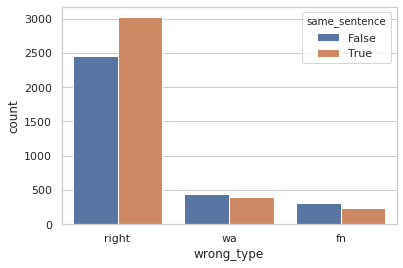

In [95]:
ax = sns.countplot(x="wrong_type", hue="same_sentence", data=df)

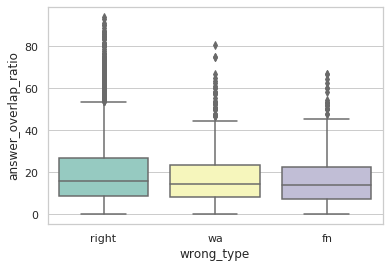

In [97]:
ax = sns.boxplot(x="wrong_type", y="answer_overlap_ratio",
                 data=df, palette="Set3")

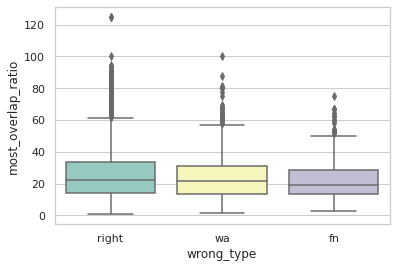

In [98]:
ax = sns.boxplot(x="wrong_type", y="most_overlap_ratio",
                 data=df, palette="Set3")

In [113]:
df_melt = df_new.melt(id_vars=['wrong_type'], var_name='dataset', value_name='values')

In [103]:
df_melt

,wrong_type,dataset,values
0,right,answer_overlap_ratio,3.703704
1,right,answer_overlap_ratio,18.518519
2,right,answer_overlap_ratio,3.030303
3,right,answer_overlap_ratio,6.060606
4,right,answer_overlap_ratio,17.857143
...,...,...,...
13723,right,most_overlap_ratio,24.137931
13724,right,most_overlap_ratio,14.285714
13725,right,most_overlap_ratio,24.137931
13726,fn,most_overlap_ratio,30.434783


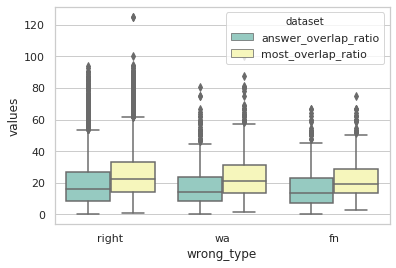

In [105]:
ax = sns.boxplot(x="wrong_type", y="values", hue = 'dataset',
                 data=df_melt, palette="Set3")

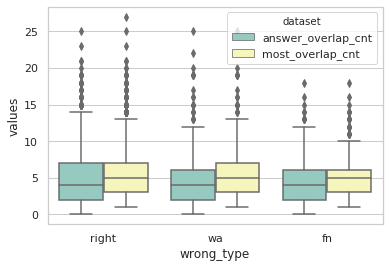

In [114]:
ax = sns.boxplot(x="wrong_type", y="values", hue = 'dataset',
                 data=df_melt, palette="Set3")